#### iris 데이터셋 활용해서 꽃잎 너비 예측 모델
 - 데이터셋 : iris.csv에서 2개의 Feature 사용
 - 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [110]:
# 모듈 로딩
import torch                                 # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                        # 인공신경망 관련 모듈
import torch.nn.functional as F              # 손실, 거래 등 함수 관련 모듈 
import torch.optim as optimizer              # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score  # 성능지표 관련 모듈  - 추가 설치
from torchinfo import summary                # 모델 정보 관련 모듈 - 추가 설치

import pandas as pd
from sklearn.model_selection import  train_test_split

In [111]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [112]:
# [1-1] 데이터 로딩
irisDF = pd.read_csv(r'C:\VSCode\KDT\Torch_DL\Data\iris.csv',usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 모델 준비
 - 학습방법 : 지도학습 > 회귀
 - 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [113]:
# 모델 설계
# 입력층에 입력값 => sepal.length, sepal.width, petal.length 3개
# 출력층의 출력값/타겟 => petal.width 1개
# 입력층    :  입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF ReLU
#                          |
#                -----------
#                | ReLU
#                V          
# 은닉층    :  입력 10, 출력 은닉층에 존재하는 퍼셉트론 개수 5, AF ReLU
#                       |
#                -------
#                | ReLU
#                v
# 출력층    :  입력 5, 출력 타겟/라벨 개수 1 , AF - None
model = nn.Sequential(nn.Linear(3,10),
                      nn.ReLU(),
                      nn.Linear(10,5),
                      nn.ReLU(),
                      nn.Linear(5,1))

In [114]:
# 모델 구조 확인
print(model)
summary(model,input_size=(20000,3))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [20000, 1]                --
├─Linear: 1-1                            [20000, 10]               40
├─ReLU: 1-2                              [20000, 10]               --
├─Linear: 1-3                            [20000, 5]                55
├─ReLU: 1-4                              [20000, 5]                --
├─Linear: 1-5                            [20000, 1]                6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 2.02
Input size (MB): 0.24
Forward/backward pass size (MB): 2.56
Params size (MB): 0.00
Estimated Total Size (MB): 2.80

In [115]:
# 가중치와 절편 확인
for name, name_parameter in model.named_parameters() :
    print(f'[{name}], [{name_parameter}],"\n"')

[0.weight], [Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)],"
"
[0.bias], [Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)],"
"
[2.weight], [Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.018

[3] 최적화 인스턴스 준비

In [116]:
### 모델의 가중치와 절편 최적화 이후 인스턴스에 전달
adam_optimizer = optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 진행 

 - [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행 or 학습 전 진행

In [117]:
irisDF.columns[:-1]

Index(['sepal.length', 'sepal.width', 'petal.length'], dtype='object')

In [118]:
# 피쳐와 타겟 분리
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[['petal.width']]

print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [119]:
# Train, Test
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetDF,
                                                   test_size = 0.2,
                                                   random_state=5)

# Train, Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                   test_size = 0.2,random_state=5)

- [4-2] 학습진행 : 
   * 학습횟수 결정 ==> 에포크 설정
   * 배치크기 결정 
   * 배치개수 계산

In [120]:
EPOCH = 100                             # 처음~끝까지 공부하는 횟수
BATCH_SIZE = 12                         # 1에포크에서 한 번 학습할 분량 크기
BATCH_CNT = X_train.shape[0]//BATCH_SIZE # 1에포크에서 총 학습 횟수이면서 업데이트 횟수
# 몫 연산자 이용해서 구함. 나머지 6개는 사용이 안됨.
print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE}, BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:12, BATCH_CNT:8


In [121]:
# 모델 테스트/검증 함수 
# ==> 가중치,절편 업데이트 X 그래서 최적화 미진행 해야함
# ==> 현재 가중치와 절편으로 테스트 진행
def testing(testDF, targetDF, kind = 'Val') :
    # Tensor화
    testTS = torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)

    with torch.no_grad() :      # 가중치 및 절편 업데이트 X
        # (1) 학습진행 forward
        pre_y = model(testTS)

        # (2) 오차계산 - 손실함수
        loss = F.mse_loss(pre_y, targetTS)

        # (3) 성능평가 - R2
        r2 = R2Score()(pre_y,targetTS)
       
        # (3) 학습 과정 출력 및 저장
        print(f'[{kind}] LOSS : {loss},R2 : {r2}')

    return loss, r2

In [122]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS) :
    # [[],[]] <= [train,val]
    loss_history = [[],[]]
    r2_history=[[],[]]

    for epoch in range(EPOCH) :
        # 배치 손실 저장 변수
        bs_loss,bs_r2=0,0

        # 배치크기 만큼 학습 진행
        for i in range(BATCH_CNT):
            start=i*BATCH_SIZE
            end = start + BATCH_SIZE
            print(start,end)
            # BATCH_SIZE 크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(BSX_train.shape, BSX_train.device,BSX_train.dtype)
            # print(BSy_train.shape, BSy_train.device,BSy_train.dtype)
        # (1) 학습진행 forward
        pre_y = model(BSX_train)
        print(f'pre_y.shape : {pre_y.shape}')

        # (2) 오차계산 - 손실함수
        loss = F.mse_loss(pre_y, BSy_train)
        bs_loss += loss.item()
        bs_r2 += R2Score()(pre_y,BSy_train).item()
       
        # (3) 최적화 - 가중치, 절편 업데이트
        adam_optimizer.zero_grad()
        loss.backward()
        adam_optimizer.step()

        # -(4) 검증 - 모델이 제대로 만들어지는 검사용
        val_loss,val_r2 = testing(valTS,valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        # (4) 학습 과정 출력
        print(f'[{epoch}/{EPOCH}]\n Train LOSS : {loss_history[0][-1]} R2 : {r2_history[0][-1]}')
        print(f'-VALID LOSS : {loss_history[1][-1]} R2 : {r2_history[1][-1]}')

    return loss_history, r2_history

In [123]:
# 모델 학습 진행
loss, r2 = training(X_train,y_train,X_val,y_val)

0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
pre_y.shape : torch.Size([12, 1])
[Val] LOSS : 0.5848502516746521,R2 : -0.4013630151748657
[0/100]
 Train LOSS : 0.11050643771886826 R2 : -0.19764670729637146
-VALID LOSS : 0.5848502516746521 R2 : -0.4013630151748657
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
pre_y.shape : torch.Size([12, 1])
[Val] LOSS : 0.31909462809562683,R2 : 0.23541557788848877
[1/100]
 Train LOSS : 0.05616157874464989 R2 : -0.038975492119789124
-VALID LOSS : 0.31909462809562683 R2 : 0.23541557788848877
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
pre_y.shape : torch.Size([12, 1])
[Val] LOSS : 0.44660958647727966,R2 : -0.07012379169464111
[2/100]
 Train LOSS : 0.033388663083314896 R2 : 0.027514800429344177
-VALID LOSS : 0.44660958647727966 R2 : -0.07012379169464111
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
pre_y.shape : torch.Size([12, 1])
[Val] LOSS : 0.2999894618988037,R2 : 0.2811935544013977
[3/100]
 Train LOSS : 0.059474777430295944 R2 : -0.048649072647

In [124]:
loss

[[0.11050643771886826,
  0.05616157874464989,
  0.033388663083314896,
  0.059474777430295944,
  0.036092039197683334,
  0.029840275645256042,
  0.03442634269595146,
  0.03712105751037598,
  0.03590769320726395,
  0.03182058408856392,
  0.02703195996582508,
  0.02457721345126629,
  0.025782383978366852,
  0.026112983003258705,
  0.021743260324001312,
  0.016687268391251564,
  0.015238749794661999,
  0.015731578692793846,
  0.014534001238644123,
  0.011103211902081966,
  0.007953658699989319,
  0.00807584822177887,
  0.008941047824919224,
  0.006574244704097509,
  0.004767171572893858,
  0.005678031127899885,
  0.005846660118550062,
  0.003665560157969594,
  0.002945281332358718,
  0.004233397543430328,
  0.004350272938609123,
  0.003631020663306117,
  0.003579590702429414,
  0.003046884201467037,
  0.003181656589731574,
  0.0029097534716129303,
  0.003044901182875037,
  0.003062579780817032,
  0.0029700181912630796,
  0.0031655889470130205,
  0.003045733319595456,
  0.003175544552505016

In [126]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

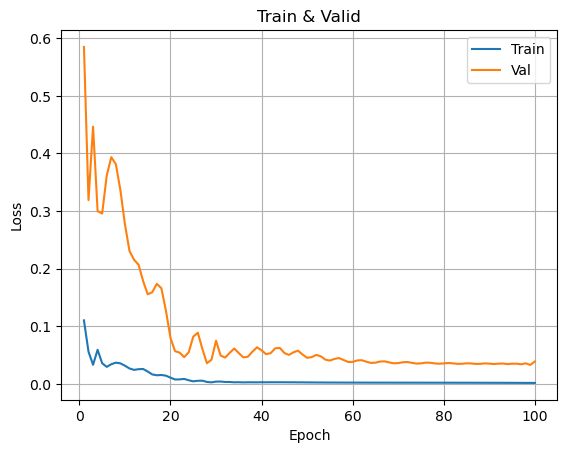

In [127]:


plt.plot(range(1,101),loss[0], label='Train')
plt.plot(range(1,101),loss[1], label='Val')
plt.title('Train & Valid')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()